In [2]:
# load basic libraries
import numpy as np
import pandas as pd
import cv2  #package for image display
import pickle
from random import shuffle
from matplotlib import pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, hamming_loss
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load libraries needed for CNN
from vgg16 import VGG16
import numpy as np
import argparse
import cv2

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras import applications
from keras import optimizers
from keras.models import Model
from keras.models import load_model
from keras.callbacks import TensorBoard
from keras.preprocessing import image as image_utils
from imagenet_utils import decode_predictions
from imagenet_utils import preprocess_input

import h5py

Using TensorFlow backend.


### Read the Poster Data

In [5]:
### read the data
data = pd.read_csv("data/top1000_movies_2011_2016_tmdb_imdb.csv")
data.shape

# extract movies with poster information
index = np.zeros(data.shape[0])

for i in range(data.shape[0]):
    try:
        np.isnan(data.iloc[i, 0])
    except:
        index[i] = 1
        
print ("There are {} movies without poster.".format(np.sum(index == 0)))

# extract data with poster
data_with_poster = data.iloc[index == 1, ]
print ("Final data dimension:")
data_with_poster.shape

There are 103 movies without poster.
Final data dimension:


(5893, 39)

In [6]:
###### read each image and resize ######
# Each poster is read and normalized
# inserted to the center of an array of zeros to ensure the same size

# total number of posters
n = data_with_poster.shape[0]

# target image size
target_length = 180
target_width = 128

# np.array to store the whole matrix in the order of the movie id
img_matrix = np.zeros([n, target_length, target_width, 3])

for i in range(n):
    if i % 1000 == 0:    
        print (i)    
    
    # read each movie id
    movie_id = data_with_poster["id"].values[i]
    # construct the poster path
    path = 'data/posters/' + str(movie_id) + '.jpg'
    
    # read image
    img = cv2.imread(path)
    
    # normalize the image[-1,1], center at 0
    # so that the zero padding does not affect the image
    img = img.astype('float32')
    img = (img - 255/2)/255
    
    # extract the length and width of the image
    img_length, img_width = np.asarray(img.shape[:2])
    
    ## put the image to the center of the array
    # calcuate location of the left edge
    left_loc = int(0.5*(target_width - img_width))
    # calcuate location of the top edge
    top_loc = int(0.5*(target_length - img_length))
    
    # store the image
    img_matrix[i, top_loc:(top_loc+img_length), 
               left_loc:(left_loc+img_width), :] = img
    
print ("Final data shape:")
img_matrix.shape

0
1000
2000
3000
4000
5000
Final data shape:


(5893, 180, 128, 3)

In [7]:
### reformat the data shape
if K.image_data_format() == 'channels_first':
    img_matrix = img_matrix.reshape(n, 3, target_length, target_width)
    input_shape = (3, target_length, target_width)
else:
    img_matrix = img_matrix.reshape(n, target_length, target_width, 3)
    input_shape = (target_length, target_width, 3)

print('data shape:', img_matrix.shape)

data shape: (5893, 180, 128, 3)


In [8]:
### extract and clean the response variable 
# convert genre ids to list
y = list()
for i in range(data_with_poster.shape[0]):
    genre = map(int, re.sub("[\[ \] ]", "", data['genre_ids'][i]).split(','))
    y.append(genre)

# binarize response variable (returns array)
y_binary = MultiLabelBinarizer().fit_transform(y)

In [9]:
### split the train and test data (9:1 ratio)
# shuffle the samples
seed = 109
index_2 = range(n)
shuffle(index_2)

img_matrix = img_matrix[index_2]
y_binary = y_binary[index_2]

# use 90% of the data as training data to fit the model
split_ratio = 0.9
split_num = int(n * split_ratio)

x_train = img_matrix[:split_num]
x_test = img_matrix[split_num:]

y_train = y_binary[:split_num]
y_test = y_binary[split_num:]

### Import VGG16 and tune the early convolutionary layers on the training data
No dropouts at this step, just to tune the early layers to correctly recognize the basic features.

In [8]:
### load pretrained model - VGG16
base_model =VGG16(weights='imagenet', include_top=False)
x = base_model.output 

# add fully-connected layer
x = GlobalAveragePooling2D()(x) 
# add a dense layer
x = Dense(1024, activation='relu')(x)
# the last layer has 1 class because we are predicting only 1 genre
# the activation should be sigmoid for binary prediction
predictions = Dense(1, activation='sigmoid')(x) 

# the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# set the first 11 layers (up to the second last conv block)
# to non-trainable (weights will not be updated)
# only train the early convolutionary layers
for layer in model.layers[:12]:
    layer.trainable = False

# compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=0.001, momentum=0.9),
              metrics=['accuracy'])

In [9]:
# check the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
### specify the tuning parameters
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 20
# number of iterations over the complete training data (chosen after trials)
epochs = 50

In [ ]:
# train the model
history = model.fit(x_train, y_train[:, 3],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/50
5303/5303 [==============================] - 89s - loss: 0.6622 - acc: 0.6321      

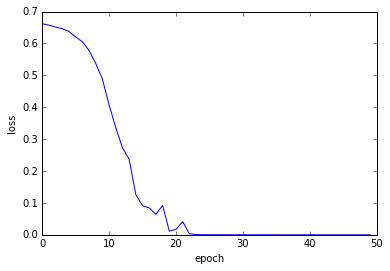

In [13]:
# check the training loss over epoch
# the model is ‘overfitted’ to the training data
# the early convolutionary layers should be able to recognize the features
plt.plot(history.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

In [15]:
# save the intermediate result
model.save('finetune_base_drama.h5')

### Fine tune the final layers
The model is tuned again with new dense layers and dropouts added. 

In [10]:
# model from the previous step
base_model = load_model('finetune_base_drama.h5')

In [11]:
# add dropouts and new dense layers
x = base_model.layers[19].output 
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(1, activation='sigmoid')(x) # sigmoid for binary prediction
model2 = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# set the first 19 layers (all the convolutionary blocks)
# to non-trainable (weights will not be updated)
for layer in model2.layers[:20]:
    layer.trainable = False

In [14]:
# set training parameters
batch_size = 20
epochs = 40
## can add early stopping (not here to better show the result)
#earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

In [15]:
# compile the model
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
# train the model on 90% of the training data
# the rest 10% is validation data 
history = model2.fit(x_train, y_train[:, 3],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    #callbacks=[earlyStopping],
                    validation_split=0.1)

Train on 4772 samples, validate on 531 samples
Epoch 1/40
4772/4772 [==============================] - 61s - loss: 0.4682 - acc: 0.8120 - val_loss: 0.3075 - val_acc: 0.9435

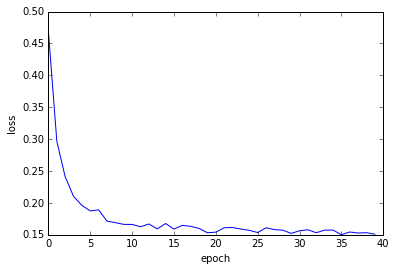

In [17]:
# show the training loss over epochs
plt.plot(history.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

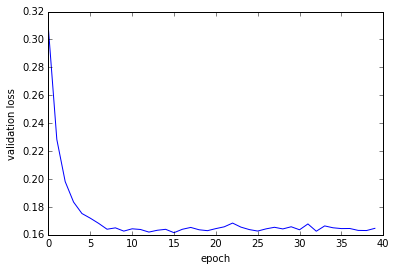

In [18]:
# show the validation loss over epochs
# the final validation loss is similar to the training loss
# suggests no overfitting
plt.plot(history.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("validation loss")

### Evaluate the model on the testing data

In [19]:
# predict on test data
y_pred = model2.predict(x_test)
y_pred = y_pred.reshape(len(y_pred))
# convert the result to binary using 0.5 as threshold
y_bin = np.zeros(len(y_pred))
y_bin[y_pred > 0.5] = 1

# extract the actual genre for each movie
y_actual = y_test[:, 3].reshape(len(y_pred))

# save the data into a csv
test_result = pd.DataFrame({
    "prediction": y_bin,
    "actual": y_actual,
    "probability": y_pred
})

test_result.to_csv("prediction_drama.csv", index = None)

In [4]:
# compute testing metrics
# read the result
result = pd.read_csv("prediction_drama.csv")

print "F1 score: ", f1_score(result["actual"], result["prediction"])
print "Accuracy: ", np.mean(result["actual"] == result["prediction"])
print "Precision: ", precision_score(result["actual"], result["prediction"])
print "Recall: ", recall_score(result["actual"], result["prediction"])
print "Hamming loss:", hamming_loss(result["actual"], result["prediction"])
confusion_matrix(result["actual"], result["prediction"])

F1 score:  0.940909090909
Accuracy:  0.95593220339
Precision:  0.93665158371
Recall:  0.945205479452
Hamming loss: 0.0440677966102


array([[357,  14],
       [ 12, 207]])